In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import joblib
from pathlib import Path
import pickle
import gpytorch
import json

In [5]:
from models import Ridge
from gp_models import ExactGPModel

In [4]:
df_data = pd.read_csv('../out/ensemble-multidomain/data-stage2/phase1-main/main4-weak48s-indomain-opt/test-X.csv', index_col=0)
column_names = df_data.columns.values
column_names

array(['pred-fancy-surf-27', 'pred-polar-flower-28',
       'pred-likely-leaf-29', 'pred-cosmic-water-30',
       'pred-phase1-main---ridge---w2v_small',
       'pred-phase1-main---ridge---w2v_large',
       'pred-phase1-main---ridge---w2v_large2',
       'pred-phase1-main---ridge---w2v_xlsr',
       'pred-phase1-main---ridge---hubert_base',
       'pred-phase1-main---ridge---hubert_large',
       'pred-phase1-main---ridge---wavlm_base',
       'pred-phase1-main---ridge---wavlm_large',
       'pred-phase1-main---linear_svr---w2v_small',
       'pred-phase1-main---linear_svr---w2v_large',
       'pred-phase1-main---linear_svr---w2v_large2',
       'pred-phase1-main---linear_svr---w2v_xlsr',
       'pred-phase1-main---linear_svr---hubert_base',
       'pred-phase1-main---linear_svr---hubert_large',
       'pred-phase1-main---linear_svr---wavlm_base',
       'pred-phase1-main---linear_svr---wavlm_large',
       'pred-phase1-main---kernel_svr---w2v_small',
       'pred-phase1-main---kernel

In [6]:
ridge_model = joblib.load('../out/ensemble-multidomain/stage2/phase1-main/ridge-main4-weak48s-indomain-opt/0/model.joblib')
ridge_model

Ridge(alpha=130.99990997025657)

In [7]:
df_weight = pd.Series(dict(zip(column_names, ridge_model.coef_)))


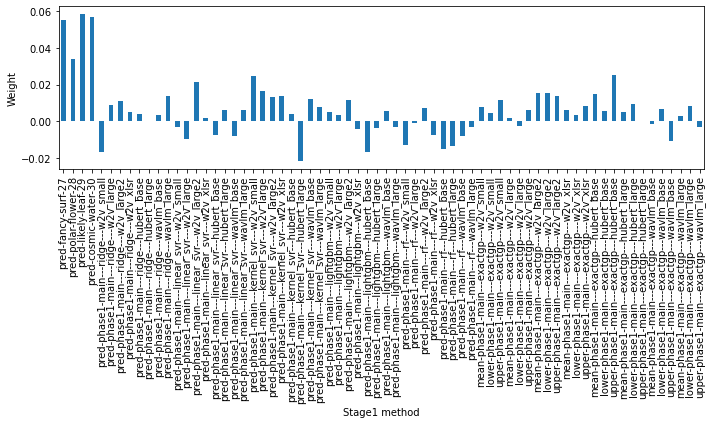

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
df_weight.plot.bar(ax=ax)
ax.set_ylabel('Weight')
ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/main-ridge_coef.pdf')

In [10]:
# !mkdir -p fig

In [40]:
# initial_inducing = torch.from_numpy(np.empty((1024, len(column_names)), dtype=np.float32))
# initial_inducing.size()

torch.Size([1024, 43])

In [17]:
model_dir = Path('../out/ensemble-multidomain/stage2/phase1-main/exactgp-main4-weak48s-indomain-opt/0')
conf = json.load(open(model_dir / 'model_config.json', 'rb'))
dummy_X = torch.from_numpy(
    np.empty(conf['input_shape'], dtype=np.float32))
dummy_y = torch.from_numpy(
    np.empty(conf['output_shape'], dtype=np.float32))
likelihood = gpytorch.likelihoods.GaussianLikelihood(
                noise_constraint=gpytorch.constraints.GreaterThan(1e-3),
            )
gpr = ExactGPModel(dummy_X, dummy_y, likelihood,
                    initial_lengthscale=1.0)
gpr.load_state_dict(torch.load(model_dir / 'model.pt', map_location='cpu'))
gpr

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-03)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [18]:
lengthscale = gpr.covar_module.base_kernel.lengthscale.detach().numpy().ravel()
lengthscale

array([ 5.72941  ,  6.5549526,  7.6854424,  7.1789865, 15.315013 ,
       58.370663 , 48.656742 , 56.61975  , 60.030365 , 59.283916 ,
       62.960773 , 14.52003  , 57.051636 , 57.784386 , 10.6051235,
       63.287003 , 63.528805 , 37.45323  , 62.830444 , 57.74611  ,
       10.79942  , 15.5662   , 49.268536 , 15.121594 , 57.89521  ,
       15.386676 , 39.616817 , 56.146183 , 61.41151  , 63.585953 ,
       59.161762 , 54.872063 , 13.771638 , 56.101837 , 31.769533 ,
       44.72713  , 35.334938 , 67.10397  , 64.958015 , 58.848984 ,
       41.270752 , 23.225925 , 40.229065 , 63.815136 , 49.137337 ,
       58.88419  , 14.150428 , 64.78232  , 65.73489  , 65.547935 ,
       51.262207 , 12.764434 , 56.08906  , 55.680477 , 65.3567   ,
       59.561596 , 27.204369 , 50.76891  ,  9.291055 , 61.406597 ,
       19.832699 , 64.83724  , 65.2338   , 58.39643  , 40.107246 ,
       66.17508  , 51.981987 , 62.123558 ], dtype=float32)

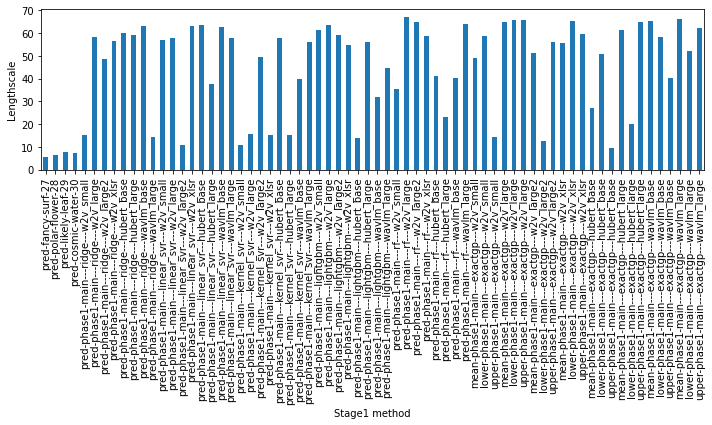

In [22]:
df_lengthscale = pd.Series(dict(zip(column_names, lengthscale)))
fig, ax = plt.subplots(1,1,figsize=(10,6))
df_lengthscale.plot.bar(ax=ax)
ax.set_ylabel('Lengthscale')
ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/main-exactgp_lengthscale.pdf')

In [20]:
lgb_path = '../out/ensemble-multidomain/stage2/phase1-main/lightgbm-main4-weak48s-indomain-opt/0/model.pkl'
lgb = pickle.load(open(lgb_path, 'rb'))
lgb.feature_importance()

array([36, 24, 39, 28,  3,  5,  8,  8,  6,  7,  3,  6,  3,  8,  9,  4,  4,
       12,  4,  5, 11,  8, 14,  8,  2,  3,  1,  5,  4,  2,  4,  7,  7,  5,
        6,  2,  8,  2,  8, 11,  9, 12, 10,  3, 15,  2, 12,  4,  3,  4, 11,
       11,  8,  9,  6,  6, 11,  6, 11,  3,  3,  6,  6,  3,  1,  3,  4,  5],
      dtype=int32)

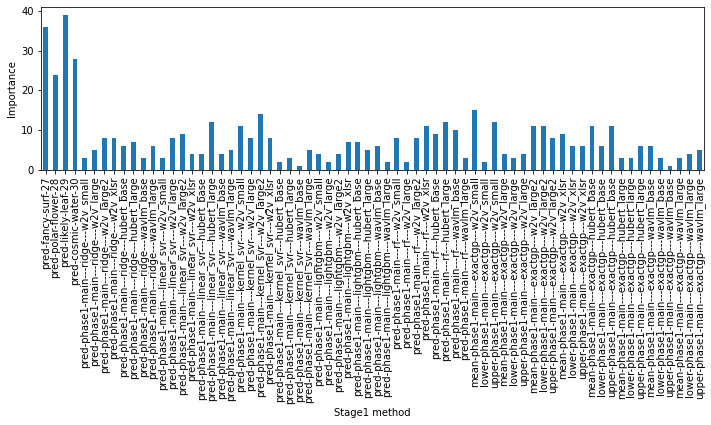

In [21]:
df_importance = pd.Series(dict(zip(column_names, lgb.feature_importance())))
fig, ax = plt.subplots(1,1,figsize=(10,6))
df_importance.plot.bar(ax=ax)
ax.set_ylabel('Importance')
ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/main-lightgbm_importance.pdf')